#Project In Progress
___

# Some installations

In [1]:
!pip -q install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip -q install ale-py

In [3]:
!pip -q install "gymnasium[atari,accept-rom-license,other]" ale-py

In [ ]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
import collections
from collections import namedtuple,deque

import cv2

gym.register_envs(ale_py)


# ========================
# FireResetEnv
# ========================
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)

        # Gymnasium step returns 5 values
        obs, _, terminated, truncated, info = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset()

        obs, _, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            obs, info = self.env.reset()

        return obs, info

    def step(self, action):
        return self.env.step(action)


# ========================
# MaxAndSkipEnv
# ========================
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, *, seed=None, options=None):
        self._obs_buffer.clear()
        obs, info = self.env.reset(seed=seed, options=options)
        self._obs_buffer.append(obs)
        return obs, info


# ========================
# Preprocessing function
# ========================
def prepro(I):
    """Preprocess 210x160x3 uint8 frame into 80x80 float array"""
    I = I[35:195]           # crop
    I = I[::2, ::2, 0]      # downsample by factor of 2, take red channel
    I[I == 144] = 0         # erase background (background type 1)
    I[I == 109] = 0         # erase background (background type 2)
    I[I != 0] = 1           # everything else (paddles, ball) set to 1
    return I.astype(np.float32)


# ========================
# PreproWrapper (replaces ProcessFrame84 and ScaledFloatFrame)
# ========================
class PreproWrapper(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(PreproWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(80, 80, 1), dtype=np.float32
        )

    def observation(self, obs):
        processed_frame = prepro(obs)
        return processed_frame.reshape(80, 80, 1) # Ensure channel dimension for ImageToPyTorch


# ========================
# ImageToPyTorch
# ========================
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.float32,
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


# ========================
# BufferWrapper
# ========================
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space

        self.observation_space = gym.spaces.Box(
            low=np.repeat(old_space.low, n_steps, axis=0),
            high=np.repeat(old_space.high, n_steps, axis=0),
            dtype=dtype,
        )
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer.fill(0) # Clear buffer on reset
        for _ in range(self.observation_space.shape[0] // obs.shape[0]):
             self.buffer = np.roll(self.buffer, obs.shape[0], axis=0)
             self.buffer[:obs.shape[0]] = obs
        return self.buffer, info

    def observation(self, observation):
        self.buffer = np.roll(self.buffer, observation.shape[0], axis=0)
        self.buffer[:observation.shape[0]] = observation
        return self.buffer


# ========================
# make_env
# ========================
def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = PreproWrapper(env)  # Use PreproWrapper for 80x80 processing
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return env # ScaledFloatFrame is no longer needed after PreproWrapper

# Let's Start The Project

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
gym.register_envs(ale_py)

In [ ]:
env=gym.make("ALE/SpaceInvaders-v5")

In [ ]:
image_of_game=env.reset(seed=41)

In [ ]:
frame_dim=image_of_game[0].shape
print(f'The Frame Dimensions Are:{frame_dim}')

The Frame Dimensions Are:(210, 160, 3)


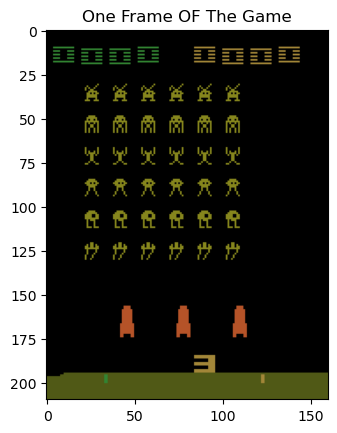

In [ ]:
plt.title('One Frame OF The Game')
plt.imshow(image_of_game[0])

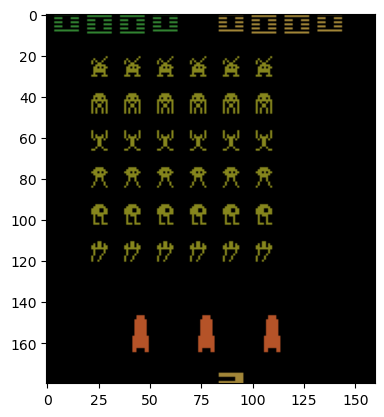

In [ ]:
plt.imshow(image_of_game[0][10:190])

In [ ]:
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 6



* 0=> NOOP,
* 1=> FIRE,
* 2=> RIGHT,
* 3=> LEFT,
* 4=> RIGHTFIRE,
* 5=> LEFTFIRE

In [ ]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [ ]:
new_image=env.step(1)

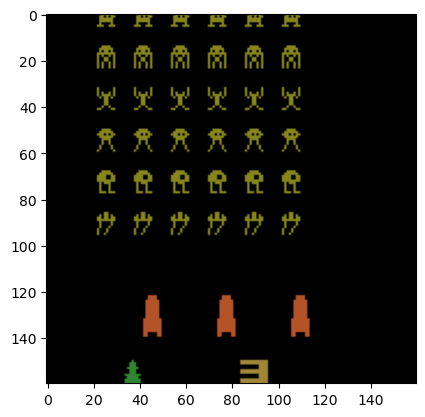

In [ ]:
plt.imshow(new_image[0][35:195])


# Make Frames 80x80 float array

In [ ]:
# The 'prepro' function has been moved into the 'TBwJYjAQ-bdo' cell within the PreproWrapper class definition.
# This cell can now be considered empty or removed if desired.

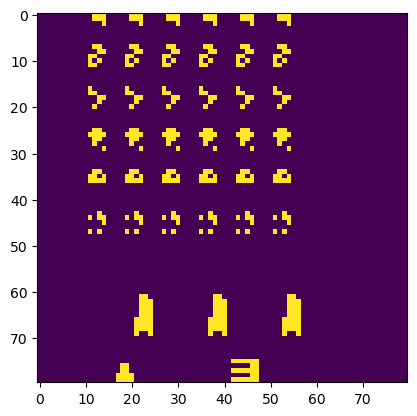

In [ ]:
prepro_frame=prepro(new_image[0])
plt.imshow(prepro_frame)
#This is what my model will see

In [ ]:
class DQNet(nn.Module):
    def __init__(self, action_size):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # Compute conv output dynamically
        def _get_conv_output(shape):
            o = self.conv1(torch.zeros(1, *shape))
            o = self.conv2(o)
            o = self.conv3(o)
            return int(np.prod(o.size()))

        conv_out_size = _get_conv_output((4, 80, 80))
        self.head = nn.Linear(conv_out_size, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.head(x)


In [ ]:
LEARNING_RATE=1e-4
BATCH_SIZE=32
GAMMA=0.99
BUFFER_SIZE=int(1e5)
TAU=1e-3

In [ ]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):


        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed=random.seed(seed)

    def add_exp(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state,done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        # Remove unsqueeze(1) as the states will already be stacked (4 channels)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
class Agent:
    def __init__(self, env, seed):
        self.env = env
        self.action_size = env.action_space.n
        self.qnet_local = DQNet(self.action_size).to(device)
        self.qnet_target = DQNet(self.action_size).to(device)
        self.optimizer = torch.optim.AdamW(self.qnet_local.parameters(), lr=5e-5)
        self.memory = ReplayBuffer(int(1e5), 64, seed)
        self.t_step = 0

        # Frame stacking is now handled by the environment wrappers

    def step(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0 and len(self.memory) > 64:
            self.learn(64, 0.99)

    def act(self, stacked_state, eps=0.0):
        # The incoming state is already stacked by the environment wrappers
        state_tensor = torch.from_numpy(stacked_state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state_tensor)
        self.qnet_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, batch_size, gamma):
        experiences = self.memory.sample()
        states, actions, rewards, next_states, dones = experiences

        # Double DQN
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnet_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.qnet_local.parameters(), 10.0)
        self.optimizer.step()

        self.soft_update(self.qnet_local, self.qnet_target, 1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
import os

# Define global constants for Agent initialization
LEARNING_RATE=(1e-4)
BATCH_SIZE=32
GAMMA=0.99
TAU=1e-3

# Epsilon-greedy policy parameters
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.995 # Decay rate per episode

# Training loop parameters (also defined globally previously)
num_episodes = 10000
save_every = 100

# Instantiate the agent using the updated classes before the training loop
# Ensure 'env' is defined from previous cells
# Use the make_env function to apply all wrappers
env = make_env("ALE/SpaceInvaders-v5")
agent = Agent(env=env, seed=41)

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# --- Start: Checkpoint loading and variable initialization (moved from previous cell) ---
checkpoint_path = 'spaceinvaders_checkpoint.pt' # Assuming this is the last saved full checkpoint

# Initialize default values in case no checkpoint is found
start_episode = 0
eps = eps_start # From global parameters
reward_history = []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dicts
    agent.qnet_local.load_state_dict(checkpoint['model_state_dict'])
    agent.qnet_target.load_state_dict(checkpoint['model_state_dict']) # Target model is often initialized from local

    # Load optimizer state dict
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load other training parameters
    start_episode = checkpoint['episode'] + 1
    eps = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']

    print(f"Resuming training from episode {start_episode} with epsilon {eps:.4f}")
    print(f"Loaded reward history length: {len(reward_history)}")
already_exists = os.path.exists(mean_rewards_filepath)

# --- End: Checkpoint loading and variable initialization ---


# Open the file in append mode or create if it doesn't exist. Write header if new.
# This part assumes a new or clean run if `start_episode` is 0.
# If resuming, you might want to ensure the file is correctly appended to.
if start_episode == 0 and already_exists:
    os.remove(mean_rewards_filepath)
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(start_episode, num_episodes):
    # Reset environment, it now returns the already stacked initial state
    current_stacked_state, info = env.reset()

    ep_reward = 0
    step_count = 0

    while True:
        # Select action using the agent's epsilon-greedy policy with the current stacked state
        action = agent.act(current_stacked_state, eps)

        # Perform action in environment, it now returns the already stacked next state
        next_stacked_state, reward, terminated, truncated, info = env.step(action)

        # Store experience and trigger learning
        agent.step(current_stacked_state, action, reward, next_stacked_state, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update current_stacked_state for the next iteration
        current_stacked_state = next_stacked_state

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')

        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint_{episode}.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Episode    0, Reward:  120.00, Epsilon: 0.9950, Steps: 122
Episode    1, Reward:   65.00, Epsilon: 0.9900, Steps: 122
Episode    2, Reward:  215.00, Epsilon: 0.9851, Steps: 210
Episode    3, Reward:  120.00, Epsilon: 0.9801, Steps: 127
Episode    4, Reward:   50.00, Epsilon: 0.9752, Steps: 73
Episode    5, Reward:   85.00, Epsilon: 0.9704, Steps: 91
Episode    6, Reward:  175.00, Epsilon: 0.9655, Steps: 227
Episode    7, Reward:   80.00, Epsilon: 0.9607, Steps: 103
Episode    8, Reward:  130.00, Epsilon: 0.9559, Steps: 146
Episode    9, Reward:   65.00, Epsilon: 0.9511, Steps: 109
Episode   10, Reward:   45.00, Epsilon: 0.9464, Steps: 95
Episode   11, Reward:   95.00, Epsilon: 0.9416, Steps: 118
Episode   12, Reward:   30.00, Epsilon: 0.9369, Steps: 68
Episode   13, Reward:   35.00, Epsilon: 0.9322, Steps: 100
Episode   14, Reward:  315.00, Epsilon: 0.9276, Steps: 219
Episode   15, Reward:   70.00, Epsilon: 0.9229, Steps: 146
Episode   16, Reward:   30.00, Epsilon: 0.9183, Steps: 94
Ep

In [ ]:
import pandas as pd
rewards_mean=pd.read_csv("C:\\Users\\geono\\AppData\\Local\\Programs\\Microsoft VS Code\\spaceinvaders_mean_rewards.csv")

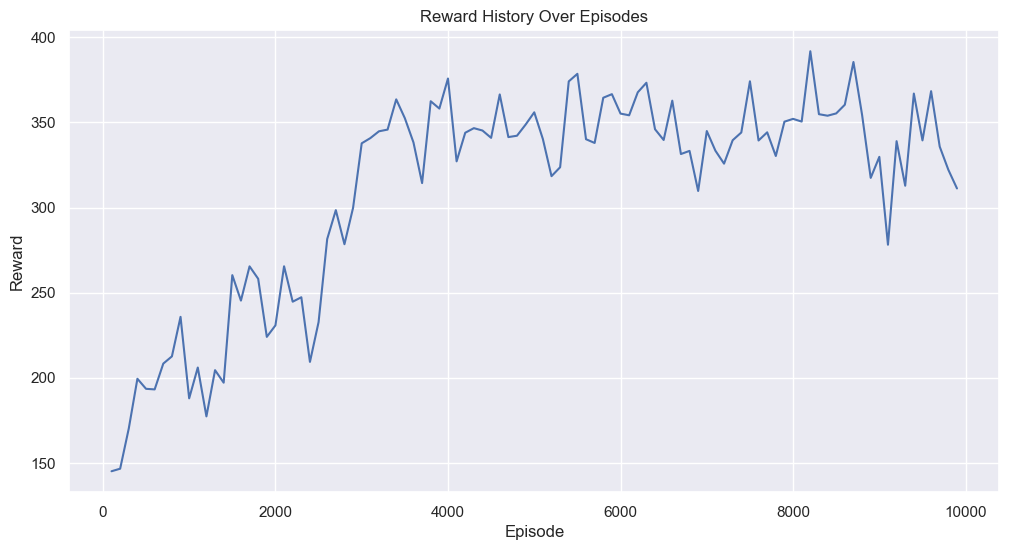

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.set(style="darkgrid")
sns.lineplot(x=rewards_mean['episode'],y=rewards_mean['mean_reward'])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History Over Episodes')
plt.show()

# Second Try I Add ..

In [ ]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
import collections
from collections import namedtuple,deque

import cv2


gym.register_envs(ale_py)


# ========================
# FireResetEnv
# ========================
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)

        # Gymnasium step returns 5 values
        obs, _, terminated, truncated, info = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset()

        obs, _, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            obs, info = self.env.reset()

        return obs, info

    def step(self, action):
        return self.env.step(action)


# ========================
# MaxAndSkipEnv
# ========================
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, *, seed=None, options=None):
        self._obs_buffer.clear()
        obs, info = self.env.reset(seed=seed, options=options)
        self._obs_buffer.append(obs)
        return obs, info


# ========================
# ProcessFrame84
# ========================
class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84, 1), dtype=np.uint8
        )

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = frame.reshape(210, 160, 3).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = frame.reshape(250, 160, 3).astype(np.float32)
        else:
            raise ValueError("Unknown resolution.")

        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = x_t.reshape(84, 84, 1)

        return x_t.astype(np.uint8)


# ========================
# ImageToPyTorch
# ========================
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.float32,
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


# ========================
# ScaledFloatFrame
# ========================
class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


# ========================
# BufferWrapper
# ========================
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space

        self.observation_space = gym.spaces.Box(
            low=np.repeat(old_space.low, n_steps, axis=0),
            high=np.repeat(old_space.high, n_steps, axis=0),
            dtype=dtype,
        )

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


# ========================
# make_env
# ========================
def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)


In [ ]:
env=make_env("ALE/SpaceInvaders-v5")
state, info=env.reset()
print(f'State Shape After Wrappers: {state.shape}')


State Shape After Wrappers: (4, 84, 84)


In [ ]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):


        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed=random.seed(seed)

    def add_exp(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state,done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        # Remove unsqueeze(1) as the states will already be stacked (4 channels)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
import torch
import torch.nn as nn

import numpy as np


class DQNet(nn.Module):
    def __init__(self, action_size):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # Compute conv output dynamically
        def _get_conv_output(shape):
            o = self.conv1(torch.zeros(1, *shape))
            o = self.conv2(o)
            o = self.conv3(o)
            return int(np.prod(o.size()))

        conv_out_size = _get_conv_output((4, 80, 80))
        self.head = nn.Linear(conv_out_size, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.head(x)


In [ ]:
BATCH_SIZE=32
BATCH_SIZE_DEQUE=int(1e5)

In [ ]:
class Agent:
    def __init__(self, env, seed):
        self.env = env
        self.action_size = env.action_space.n
        self.qnet_local = DQNet(self.action_size).to(device)
        self.qnet_target = DQNet(self.action_size).to(device)
        self.optimizer = torch.optim.Adam(self.qnet_local.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayBuffer(BATCH_SIZE_DEQUE, BATCH_SIZE, seed)
        self.t_step = 0

        # Frame stacking is now handled by the environment wrappers

    def step(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(BATCH_SIZE, 0.99)

    def act(self, stacked_state, eps=0.0):
        # The incoming state is already stacked by the environment wrappers
        state_tensor = torch.from_numpy(stacked_state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state_tensor)
        self.qnet_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, batch_size, gamma):
        experiences = self.memory.sample()
        states, actions, rewards, next_states, dones = experiences

        # Double DQN
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnet_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.qnet_local.parameters(), 10.0)
        self.optimizer.step()

        self.soft_update(self.qnet_local, self.qnet_target, 1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
import os

# Define global constants for Agent initialization
LEARNING_RATE=(1e-4)
GAMMA=0.99
TAU=1e-3

# Epsilon-greedy policy parameters
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.999 # Decay rate per episode

# Training loop parameters (also defined globally previously)
num_episodes = 10000
save_every = 100

# Instantiate the agent using the updated classes before the training loop
# Ensure 'env' is defined from previous cells
# Use the make_env function to apply all wrappers
env = make_env("ALE/SpaceInvaders-v5")
agent = Agent(env=env, seed=41)

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# --- Start: Checkpoint loading and variable initialization (moved from previous cell) ---
checkpoint_path = 'spaceinvaders_checkpoint.pt' # Assuming this is the last saved full checkpoint

# Initialize default values in case no checkpoint is found
start_episode = 0
eps = eps_start # From global parameters
reward_history = []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dicts
    agent.qnet_local.load_state_dict(checkpoint['model_state_dict'])
    agent.qnet_target.load_state_dict(checkpoint['model_state_dict']) # Target model is often initialized from local

    # Load optimizer state dict
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load other training parameters
    start_episode = checkpoint['episode'] + 1
    eps = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']

    print(f"Resuming training from episode {start_episode} with epsilon {eps:.4f}")
    print(f"Loaded reward history length: {len(reward_history)}")
already_exists = os.path.exists(mean_rewards_filepath)

# --- End: Checkpoint loading and variable initialization ---


# Open the file in append mode or create if it doesn't exist. Write header if new.
# This part assumes a new or clean run if `start_episode` is 0.
# If resuming, you might want to ensure the file is correctly appended to.
if start_episode == 0 and already_exists:
    os.remove(mean_rewards_filepath)
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(start_episode, num_episodes):
    # Reset environment, it now returns the already stacked initial state
    current_stacked_state, info = env.reset()

    ep_reward = 0
    step_count = 0

    while True:
        # Select action using the agent's epsilon-greedy policy with the current stacked state
        action = agent.act(current_stacked_state, eps)

        # Perform action in environment, it now returns the already stacked next state
        next_stacked_state, reward, terminated, truncated, info = env.step(action)

        # Store experience and trigger learning
        agent.step(current_stacked_state, action, reward, next_stacked_state, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update current_stacked_state for the next iteration
        current_stacked_state = next_stacked_state

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')

        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint_dest.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Episode    0, Reward:   55.00, Epsilon: 0.9990, Steps: 89
Episode    1, Reward:  315.00, Epsilon: 0.9980, Steps: 228
Episode    2, Reward:   80.00, Epsilon: 0.9970, Steps: 84
Episode    3, Reward:   80.00, Epsilon: 0.9960, Steps: 71
Episode    4, Reward:   80.00, Epsilon: 0.9950, Steps: 71
Episode    5, Reward:  180.00, Epsilon: 0.9940, Steps: 161
Episode    6, Reward:   50.00, Epsilon: 0.9930, Steps: 104
Episode    7, Reward:  335.00, Epsilon: 0.9920, Steps: 199
Episode    8, Reward:  140.00, Epsilon: 0.9910, Steps: 115
Episode    9, Reward:  190.00, Epsilon: 0.9900, Steps: 152
Episode   10, Reward:   30.00, Epsilon: 0.9891, Steps: 86
Episode   11, Reward:   95.00, Epsilon: 0.9881, Steps: 119
Episode   12, Reward:  165.00, Epsilon: 0.9871, Steps: 123
Episode   13, Reward:  575.00, Epsilon: 0.9861, Steps: 217
Episode   14, Reward:  385.00, Epsilon: 0.9851, Steps: 220
Episode   15, Reward:  375.00, Epsilon: 0.9841, Steps: 196
Episode   16, Reward:   65.00, Epsilon: 0.9831, Steps: 71
Epi

Text(0.5, 0, 'Episode')

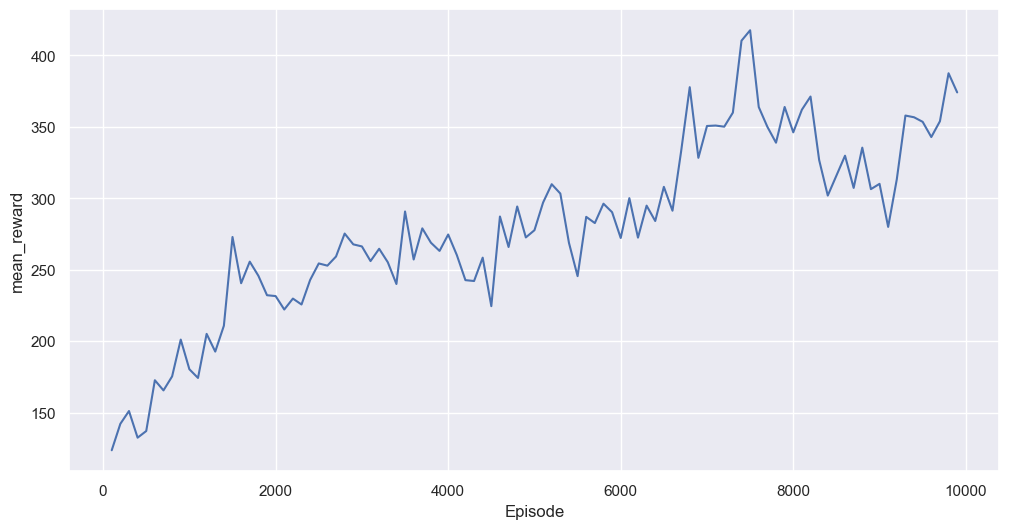

In [ ]:
import pandas as pd
import seaborn as sns
rewards_mean=pd.read_csv("C:\\Users\\geono\\AppData\\Local\\Programs\\Microsoft VS Code\\spaceinvaders_mean_rewards.csv")
plt.figure(figsize=(12,6))
sns.set(style="darkgrid")
sns.lineplot(x=rewards_mean['episode'],y=rewards_mean['mean_reward'])
plt.xlabel('Episode')

# TRD TRY

In [4]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
import collections
from collections import namedtuple,deque

import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gym.register_envs(ale_py)


# ========================
# FireResetEnv
# ========================
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)

        # Gymnasium step returns 5 values
        obs, _, terminated, truncated, info = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset()

        obs, _, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            obs, info = self.env.reset()

        return obs, info

    def step(self, action):
        return self.env.step(action)


# ========================
# MaxAndSkipEnv
# ========================
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, *, seed=None, options=None):
        self._obs_buffer.clear()
        obs, info = self.env.reset(seed=seed, options=options)
        self._obs_buffer.append(obs)
        return obs, info


# ========================
# ProcessFrame84
# ========================
class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84, 1), dtype=np.uint8
        )

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = frame.reshape(210, 160, 3).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = frame.reshape(250, 160, 3).astype(np.float32)
        else:
            raise ValueError("Unknown resolution.")

        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = x_t.reshape(84, 84, 1)

        return x_t.astype(np.uint8)


# ========================
# ImageToPyTorch
# ========================
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.float32,
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


# ========================
# ScaledFloatFrame
# ========================
class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


# ========================
# BufferWrapper
# ========================
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space

        self.observation_space = gym.spaces.Box(
            low=np.repeat(old_space.low, n_steps, axis=0),
            high=np.repeat(old_space.high, n_steps, axis=0),
            dtype=dtype,
        )

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


# ========================
# make_env
# ========================
def make_env(env_name):
    env = gym.make(env_name)
    env = FireResetEnv(env)
    env = MaxAndSkipEnv(env)

    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)


In [5]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):


        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed=random.seed(seed)

    def add_exp(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state,done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        # Remove unsqueeze(1) as the states will already be stacked (4 channels)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class DQNet(nn.Module):
    def __init__(self, action_size):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # Changed kernel size from 5 to 4 and stride from 2 to 2 to match typical dueling DQN architectures
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # Changed kernel size from 5 to 3 and stride from 2 to 1
        self.bn3 = nn.BatchNorm2d(64)

        # Compute conv output dynamically to determine linear layer input size
        def _get_conv_output(shape):
            o = self.conv1(torch.zeros(1, *shape))
            o = self.conv2(o)
            o = self.conv3(o)
            return int(np.prod(o.size()))

        conv_out_size = _get_conv_output((4, 84, 84)) # Input image size is 84x84 now after ProcessFrame84

        # Dueling DQN: Value and Advantage streams
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten the output

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine streams to get Q-values
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        return value + (advantage - advantage.mean(dim=1, keepdim=True))

In [7]:

class Agent:
    def __init__(self, env, seed):
        self.env = env
        self.action_size = env.action_space.n
        self.qnet_local = DQNet(self.action_size).to(device)
        self.qnet_target = DQNet(self.action_size).to(device)
        self.optimizer = torch.optim.Adam(self.qnet_local.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayBuffer(BATCH_SIZE_DEQUE, BATCH_SIZE, seed)
        self.t_step = 0

        # Frame stacking is now handled by the environment wrappers

    def step(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(BATCH_SIZE, 0.99)

    def act(self, stacked_state, eps=0.0):
        # The incoming state is already stacked by the environment wrappers
        state_tensor = torch.from_numpy(stacked_state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state_tensor)
        self.qnet_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, batch_size, gamma):
        experiences = self.memory.sample()
        states, actions, rewards, next_states, dones = experiences

        # Double DQN
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnet_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.qnet_local.parameters(), 10.0)
        self.optimizer.step()

        self.soft_update(self.qnet_local, self.qnet_target, 1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
import os

# Define global constants for Agent initialization
LEARNING_RATE=(1e-5)
BATCH_SIZE=50_000
BATCH_SIZE_DEQUE=50_000
GAMMA=0.9999
TAU=1e-3

# Epsilon-greedy policy parameters
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.9 # Decay rate per episode

# Training loop parameters (also defined globally previously)
num_episodes = 10000
save_every = 100

# Instantiate the agent using the updated classes before the training loop
# Ensure 'env' is defined from previous cells
# Use the make_env function to apply all wrappers
env = make_env("ALE/SpaceInvaders-v5")
agent = Agent(env=env, seed=1)

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# --- Start: Checkpoint loading and variable initialization (moved from previous cell) ---
checkpoint_path = 'spaceinvaders_checkpoint.pt' # Assuming this is the last saved full checkpoint

# Initialize default values in case no checkpoint is found
start_episode = 0
eps = eps_start # From global parameters
reward_history = []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dicts
    agent.qnet_local.load_state_dict(checkpoint['model_state_dict'])
    agent.qnet_target.load_state_dict(checkpoint['model_state_dict']) # Target model is often initialized from local

    # Load optimizer state dict
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load other training parameters
    start_episode = checkpoint['episode'] + 1
    eps = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']

    print(f"Resuming training from episode {start_episode} with epsilon {eps:.4f}")
    print(f"Loaded reward history length: {len(reward_history)}")
already_exists = os.path.exists(mean_rewards_filepath)

# --- End: Checkpoint loading and variable initialization ---


# Open the file in append mode or create if it doesn't exist. Write header if new.
# This part assumes a new or clean run if `start_episode` is 0.
# If resuming, you might want to ensure the file is correctly appended to.
if start_episode == 0 and already_exists:
    os.remove(mean_rewards_filepath)
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(start_episode, num_episodes):
    # Reset environment, it now returns the already stacked initial state
    current_stacked_state, info = env.reset()

    ep_reward = 0
    step_count = 0

    while True:
        # Select action using the agent's epsilon-greedy policy with the current stacked state
        action = agent.act(current_stacked_state, eps)

        # Perform action in environment, it now returns the already stacked next state
        next_stacked_state, reward, terminated, truncated, info = env.step(action)

        # Store experience and trigger learning
        agent.step(current_stacked_state, action, reward, next_stacked_state, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update current_stacked_state for the next iteration
        current_stacked_state = next_stacked_state

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    #eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        eps = max(eps_end, eps_decay * eps)
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')


        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint_dest.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Episode 1268, Reward:  130.00, Epsilon: 0.2824, Steps: 100
Episode 1269, Reward:  315.00, Epsilon: 0.2824, Steps: 221
Episode 1270, Reward:  130.00, Epsilon: 0.2824, Steps: 133
Episode 1271, Reward:  110.00, Epsilon: 0.2824, Steps: 122
Episode 1272, Reward:  160.00, Epsilon: 0.2824, Steps: 145
Episode 1273, Reward:  270.00, Epsilon: 0.2824, Steps: 183
Episode 1274, Reward:  155.00, Epsilon: 0.2824, Steps: 135
Episode 1275, Reward:  215.00, Epsilon: 0.2824, Steps: 186
Episode 1276, Reward:  105.00, Epsilon: 0.2824, Steps: 122
Episode 1277, Reward:  290.00, Epsilon: 0.2824, Steps: 184
Episode 1278, Reward:  355.00, Epsilon: 0.2824, Steps: 138
Episode 1279, Reward:   75.00, Epsilon: 0.2824, Steps: 134
Episode 1280, Reward:   75.00, Epsilon: 0.2824, Steps: 65
Episode 1281, Reward:  110.00, Epsilon: 0.2824, Steps: 120
Episode 1282, Reward:  240.00, Epsilon: 0.2824, Steps: 147
Episode 1283, Reward:  485.00, Epsilon: 0.2824, Steps: 246
Ep

KeyboardInterrupt: 

# Task
Resume model training for Space Invaders from the `spaceinvaders_checkpoint_dest.pt` checkpoint.

## Identify Your Saved Weights

### Subtask:
Locate the specific checkpoint file (e.g., 'spaceinvaders_checkpoint_XXX.pt' or 'spaceinvaders_solved.pt') that contains the weights you wish to load. If you've uploaded a new weight file, ensure its name and path are known.


**Reasoning**:
To locate the specified checkpoint file, I need to update the `checkpoint_path` variable in the designated cell. This action directly addresses the instruction to point to 'spaceinvaders_checkpoint_dest.pt'.



In [9]:
import os

# Define global constants for Agent initialization
LEARNING_RATE=(1e-5)
BATCH_SIZE=50_000
BATCH_SIZE_DEQUE=50_000
GAMMA=0.9999
TAU=1e-3

# Epsilon-greedy policy parameters
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.9 # Decay rate per episode

# Training loop parameters (also defined globally previously)
num_episodes = 10000
save_every = 100

# Instantiate the agent using the updated classes before the training loop
# Ensure 'env' is defined from previous cells
# Use the make_env function to apply all wrappers
env = make_env("ALE/SpaceInvaders-v5")
agent = Agent(env=env, seed=1)

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# --- Start: Checkpoint loading and variable initialization (moved from previous cell) ---
checkpoint_path = 'spaceinvaders_checkpoint_dest.pt' # Updated path

# Initialize default values in case no checkpoint is found
start_episode = 0
eps = eps_start # From global parameters
reward_history = []

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dicts
    agent.qnet_local.load_state_dict(checkpoint['model_state_dict'])
    agent.qnet_target.load_state_dict(checkpoint['model_state_dict']) # Target model is often initialized from local

    # Load optimizer state dict
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load other training parameters
    start_episode = checkpoint['episode'] + 1
    eps = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']

    print(f"Resuming training from episode {start_episode} with epsilon {eps:.4f}")
    print(f"Loaded reward history length: {len(reward_history)}")
already_exists = os.path.exists(mean_rewards_filepath)

# --- End: Checkpoint loading and variable initialization ---


# Open the file in append mode or create if it doesn't exist. Write header if new.
# This part assumes a new or clean run if `start_episode` is 0.
# If resuming, you might want to ensure the file is correctly appended to.
if start_episode == 0 and already_exists:
    os.remove(mean_rewards_filepath)
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(start_episode, num_episodes):
    # Reset environment, it now returns the already stacked initial state
    current_stacked_state, info = env.reset()

    ep_reward = 0
    step_count = 0

    while True:
        # Select action using the agent's epsilon-greedy policy with the current stacked state
        action = agent.act(current_stacked_state, eps)

        # Perform action in environment, it now returns the already stacked next state
        next_stacked_state, reward, terminated, truncated, info = env.step(action)

        # Store experience and trigger learning
        agent.step(current_stacked_state, action, reward, next_stacked_state, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update current_stacked_state for the next iteration
        current_stacked_state = next_stacked_state

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    #eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        eps = max(eps_end, eps_decay * eps)
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')


        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint_dest.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Resuming training from episode 6001 with epsilon 0.0018
Loaded reward history length: 6001
Episode 6001, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6002, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6003, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6004, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6005, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6006, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6007, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6008, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6009, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6010, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6011, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6012, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6013, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6014, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6015, Reward:  285.00, Epsilon: 0.0018, Steps: 181
Episode 6016, Reward:  2

KeyboardInterrupt: 